<a href="https://colab.research.google.com/github/ToluClassics/Twitter-Streaming-Sentiment-Analysis/blob/master/Twitter_Streaming_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import tweepy and store the credentials from twitter app
import sys
import tweepy
import importlib
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor


from google.colab import drive
import importlib.util
import json

# Load your module
spec = importlib.util.spec_from_file_location("credentials", "/content/drive/My Drive/Colab Notebooks/credentials.py")
credentials = importlib.util.module_from_spec(spec)
spec.loader.exec_module(credentials)





ACCESS_TOKEN = credentials.ACCESS_TOKEN
ACCESS_TOKEN_SECRET = credentials.ACCESS_TOKEN_SECRET
CONSUMER_KEY = credentials.CONSUMER_KEY
CONSUMER_SECRET = credentials.CONSUMER_SECRET


In [4]:
!pip install yweather

  Created wheel for yweather: filename=yweather-0.1.1-cp36-none-any.whl size=6848 sha256=2d024bfdba731ded4fc51ab1e2b892925917b55a4b7889300ae89a605589596f
  Stored in directory: /root/.cache/pip/wheels/d8/0e/d7/1a3ce8a90c15fa7fb1f74b2c34cde7cc7cf58e8c86a07e3deb
Successfully built yweather


In [5]:
import math
#a function that calculates geo distance using the latitude and longitude
def getBoundsFromLatLng(lat, lng,distance):
  lat_change = int(distance)/111.2;
  lon_change = abs(math.cos(lat*(math.pi/180)));
  bounds = []  
  bounds.append(lat - lat_change)
  bounds.append(lng - lon_change)
  bounds.append(lat + lat_change)
  bounds.append(lng + lon_change)

  return bounds;


geo_distance = getBoundsFromLatLng(6.605874,3.349149,100)
geo_distance

[5.706593424460432, 2.3557880230502546, 7.505154575539568, 4.342509976949746]

In [0]:
import yweather
client = yweather.Client()
naija_id = client.fetch_woeid('Nigeria')

In [0]:
#this class is used to streamline tweets to user timelines
class TwitterClient():
  def __init__(self,twitter_user=None):
    self.auth = Authentication(CONSUMER_KEY,CONSUMER_SECRET,ACCESS_TOKEN,ACCESS_TOKEN_SECRET).authenticate()
    self.twitter_client = API(self.auth)
    self.twitter_user = twitter_user

  def get_timeline_tweets(self,num_tweets):
    tweets = []
    for tweet in Cursor(self.twitter_client.user_timeline,id =self.twitter_user ).items(num_tweets):
      tweets.append(tweet)
    
    return tweets

  def get_twitter_api(self):
    return self.twitter_client

  def get_friend_list(self,num_friends):
    friends = []
    for friend in Cursor(self.twitter_client.friends,id =self.twitter_user).items(num_friends):
      friends.append(friend)
    
    return friends

  def get_hometimeline_tweets(self,num_tweets):
    home_tweets = []
    for tweet in Cursor(self.twitter_client.home_timeline).items(num_tweets):
      home_tweets.append(tweet)
    
    return home_tweets

#this handles the authentication to the twitter streaming API
class Authentication():
  def __init__(self,CONSUMER_KEY,CONSUMER_SECRET,ACCESS_TOKEN,ACCESS_TOKEN_SECRET):
    self.CONSUMER_KEY = CONSUMER_KEY
    self.CONSUMER_SECRET = CONSUMER_SECRET
    self.ACCESS_TOKEN = ACCESS_TOKEN
    self.ACCESS_TOKEN_SECRET = ACCESS_TOKEN_SECRET

  def authenticate(self):
    auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

    return auth
    

class TwitterStreamer():
  """
  Class that streams tweets and processes them
  """
  def stream_tweets_location(self,tweet_filename,location_list,auth):
 
    listener = StdOutListener(tweet_filename)
    auth = auth.authenticate()

    stream = Stream(auth,listener)
    stream.filter(locations=location_list)

  def stream_tweets_keywords(self,tweet_filename,keyword_list,auth):
 
    listener = StdOutListener(tweet_filename)
    auth = auth.authenticate()

    stream = Stream(auth,listener)
    stream.filter(track=keyword_list)

#Define a class that inherits from the stream listener class
class StdOutListener(StreamListener):
  """
  Class that prints the listened tweets to command lline
  """
  def __init__(self,tweet_filename):
    self.tweet_filename = tweet_filename

  def on_data(self,data):
    try:
      #print(data)
      #write the tweets to a json file
      with open(self.tweet_filename,'a') as tf:
        tf.write(data)
    except BaseException as e:
      print(str(e))
    return True
  
  def on_error(self,status):
    #return False in case of a twiitter limit error
    if status == 420:
      return False
    print(status)


In [0]:
if __name__ == "__main__":
  location_list = geo_distance
  keywords = ['Abba','Kyari']
  tweet_filename = "/content/drive/My Drive/Sentiment Analysis/twitter.txt"
  #calling the authentication class to authenticate the user
  auth = Authentication(CONSUMER_KEY,CONSUMER_SECRET,ACCESS_TOKEN,ACCESS_TOKEN_SECRET)

  twitter_streamer = TwitterStreamer()
  #user_tweets_location = twitter_streamer.stream_tweets_location(tweet_filename,location_list,auth)

  user_tweets_location = twitter_streamer.stream_tweets_keywords(tweet_filename,keywords,auth)



  #twitter_client = TwitterClient('ToluClassics')
  #user_tweets=twitter_client.get_timeline_tweets(100)

In [0]:
"""
DO NOT RUN!!!!!!
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re


class TweetAnalyzer():

  def tweets_to_dataframe(self,tweet_file_path):

    with open(tweet_file_path) as f_in:
      data = f_in.read()
    
    tweets = data.split('\n')

    df = pd.DataFrame(data=[json.loads(tweet)['text'] for tweet in tweets],columns = ["Tweets"])
    df['Tweet_Length'] = [len(json.loads(tweet)['text']) for tweet in tweets]
    df['Retweets'] = [json.loads(tweet)['retweet_count'] for tweet in tweets]
    df['Tweet Id'] = [json.loads(tweet)['id'] for tweet in tweets]
    df['Source'] = [json.loads(tweet)['source'] for tweet in tweets]
    df['likes'] = [json.loads(tweet)['favorite_count'] for tweet in tweets]
    df['date'] = [json.loads(tweet)['created_at'] for tweet in tweets]
    df['Location'] = [json.loads(tweet)['coordinates'] for tweet in tweets]
    return df

tweetAnalyzer = TweetAnalyzer()
df = tweetAnalyzer.tweets_to_dataframe('/content/drive/My Drive/Sentiment Analysis/twitter.txt')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re


class TweetAnalyzer():

  def tweets_to_dataframe(self,tweet_file_path):

    with open(tweet_file_path) as f_in:
      data = f_in.read()
    
    tweets = data.split('\n')
    text=[]
    num_of_likes=[]
    num_of_retweets=[]

    for record in tweets:
      try:
        text.append((json.loads(record)['text']))
        num_of_likes.append((json.loads(record)['favorite_count']))
        num_of_retweets.append((json.loads(record)['retweet_count']))
      except:
        continue

    df = pd.DataFrame(data=text,columns = ["Tweets"])
    df['Number of Likes'] = [likes for likes in num_of_likes ]
    df['Number of Retweets'] = [rt for rt in num_of_retweets ]

    
    return df

tweetAnalyzer = TweetAnalyzer()
df = tweetAnalyzer.tweets_to_dataframe('/content/drive/My Drive/Sentiment Analysis/twitter.txt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df = df.sort_values(by=['Number of Likes'], ascending=False)

df.head(20)

,Tweets,Number of Likes,Number of Retweets
0,Abba Kyari: Aisha Buhari breaks silence https:...,0,0
16035,RT @channelstv: BREAKING: Ganduje Fires Commis...,0,0
16044,RT @iameneji: When you are done celebrating th...,0,0
16043,Thread.,0,0
16042,What is this one saying,0,0
16041,Abba Kyari: President Buhari faces backlash ov...,0,0
16040,"RT @AfamDeluxo: Dear @NCDCgov, \n\nOne of the ...",0,0
16039,RT @MobilePunch: PHOTOS: Abba Kyari buried in ...,0,0
16038,RT @realFFK: I have lost a friend of 40 years....,0,0
16037,RT @akunnachux: Instructive that @AIT_Online t...,0,0


In [0]:
a = '@Tolu'

a.startswith('@')
a[0:1] != '@'

In [0]:
"""
Data Cleaning and Preprocessing
Defining a function to extract all the words in a tweet using the porter stemmer algorithm and removing punctuations 
"""
def get_word_counter(tweet_dataframe):

  list_of_tweets = list(tweet_dataframe['Tweets'])

  string_oftweet_words = ' '.join(list_of_tweets)

  #string_oftweet_words = re.sub(r"[^a-zA-Z]", " ", string_oftweet_words.upper())
  string_oftweet_words = string_oftweet_words.replace("  ","")

  punctuations =  string.punctuation

  new_list = string_oftweet_words.split()

  Word_list = [(word) for word in new_list if word[0:1] != '@']

  Word_list = [(word) for word in Word_list if word [0:4] != "http"]

  Word_list = [(word) for word in Word_list if word not in punctuations]

  Word_list = [(word) for word in Word_list if word.lower() not in ['abba','aba','kyari','kyari\'s']]

  Word_list = [(word) for word in Word_list if len(word) > 3 ]

  #Word_list = [PorterStemmer().stem(word) for word in Word_list]

  string_oftweet_words =  ' '.join(Word_list)

  string_oftweet_words = string_oftweet_words.lower().replace("abba","")

  string_oftweet_words = string_oftweet_words.lower().replace("kyari","")

  string_oftweet_words=  string_oftweet_words.lower().replace("aba","")

  string_oftweet_words = re.sub(r"[^a-zA-Z]", " ", string_oftweet_words.upper())

  return string_oftweet_words,Word_list



In [0]:

text,w_list = get_word_counter(df)


In [12]:
text

'  AISHA BUHARI BREAKS SILENCE BREAKING  GANDUJE FIRES COMMISSIONER  UNGUARDED UTTERANCES  ABOUT WHEN DONE CELEBRATING DEATH   KINDLY FIND TIME READ ABOUT LIFE  START READING RESUME   THREAD  WHAT THIS SAYING   PRESIDENT BUHARI FACES BACKLASH OVER MOVEMENT  BURIAL CHIEF STAFF DEAR PERSONS THAT MALLAM GROUND SPOTTED REMOVING PROTECTIVE GEAR PHOTOS  BURIED ABUJA HAVE LOST FRIEND YEARS  WERE CAMBRIDGE TOGETHER  WORKED FATHERS FIRM TOGETHER  REMAINED CLOSE  INSTRUCTIVE THAT THAT REPORTEDLY BARRED FROM COVERING GOVT PROGRAMME WEEKS AGO  COVERING  FUNKE AKINDELE BIRTHDAY PARTY PROSECUTED SOCIAL GATHERING  NOTHERNERS POLITICIANS GATHER  THIS TRIPS ABEG WANT SOLEMN MAYBE DISPLAY MAYBE SMALL CHOREOGRAPHY JUST WENT GERMANY WHEN COVID    CASES RISING THAT COUNTRY  CAME BACK REFUSED SELF ISOLATE AGAINST PHOTOS  BURIED ABUJA READ THIS RIGHT  THAT MADNESS PEOPLE THAT WILL EVENTUALLY CAUSE UNTOLD DESTRUCTION THIS  CORONAVIRUSINNIGERIA JUST  NCDC EVENTUALLY RELEASES      CASES  WEEKS TIME FROM PARTICU

In [16]:
from collections import Counter

Words = Counter(w_list)

Words.most_common(100)

[('that', 2856),
 ('this', 2011),
 ('death', 1933),
 ('people', 1861),
 ('with', 1819),
 ('from', 1551),
 ('Kyari’s', 1519),
 ('have', 1490),
 ('Chief', 1468),
 ('will', 1388),
 ('Mallam', 1225),
 ('Kano', 1184),
 ('Commissioner', 1181),
 ('burial', 1122),
 ('Kyari,', 1084),
 ('your', 982),
 ('Ganduje', 966),
 ('This', 962),
 ('commissioner', 949),
 ('should', 945),
 ('Works', 945),
 ('Nigeria', 943),
 ('Funke', 934),
 ('&amp;', 933),
 ('family', 888),
 ('when', 850),
 ('relieved', 836),
 ('over', 831),
 ('appointment', 823),
 ('they', 787),
 ('Infrastructure,', 782),
 ('died', 769),
 ('about', 761),
 ('been', 757),
 ('know', 755),
 ('Staff', 745),
 ('social', 736),
 ('President', 723),
 ('Buhari', 720),
 ('State', 693),
 ('Nigerians', 647),
 ('lost', 627),
 ('Nigerian', 626),
 ('just', 626),
 ('Akindele', 601),
 ('Allah', 581),
 ('seen', 569),
 ('like', 557),
 ('what', 552),
 ('late', 549),
 ('Kyari.', 541),
 ('Abuja', 538),
 ("don't", 525),
 ('celebrating', 509),
 ('BREAKING:', 508),

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def wordCloud(text, stopwords):
    background_color = str(input('white/black?: ')).strip()
    max_words= int(str(input('number of words to see?: ')).strip())
    stopwords = set(STOPWORDS)
    stopwords.update(stopwords)
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(max_font_size=50, max_words=max_words, stopwords=stopwords, background_color=background_color).generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

white/black?: black
number of words to see?: 50


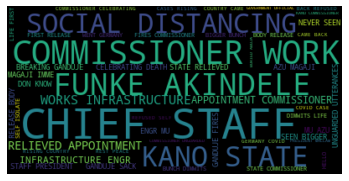

In [15]:
my_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him',\
                'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who',\
                'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',\
                'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',\
                'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there',\
                'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',\
                'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",\
                'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",\
                'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
wordCloud(text,my_stopwords)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
